In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/libraries.py content
import libraries
# Check if the Colab runtime is GPU or CPU
if libraries.torch.cuda.is_available():
    device = libraries.torch.device("cuda")
    print("Using GPU acceleration.")
    libraries.torch.backends.cudnn.deterministic = True  # Set CuDNN to deterministic mode
else:
    device = libraries.torch.device("cpu")
    print("Using CPU.")
# Set random seed for reproducibility
random_seed = 42
libraries.torch.manual_seed(random_seed)
# If using GPU, set CUDA seed
if device.type == "cuda":
    libraries.torch.cuda.manual_seed(random_seed)


Using CPU.


In [ ]:
!pip install torchviz
!pip install torchsummary
!apt-get install graphviz -y
!pip install graphviz
!pip install Pillow
from torchviz import make_dot


In [ ]:

# Define the data path
DATA_PATH = '/content/drive/MyDrive/sipakmed/sipakmed/'

In [ ]:
# Import the module
!cp /content/drive/MyDrive/sipakmed/modular/dataset_management.py /content

import dataset_management


i used this to check now how many files i have knowing that my data for sipakmed originally were 4049 bmb files

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/sipakmed/modular')

import libraries
# Get a list of all image file paths
file_paths = []
categories = []

for root, dirs, files in libraries.os.walk(DATA_PATH):
    for file in files:
        if file.endswith('.bmp'):
            file_path = libraries.os.path.join(root, file)
            file_paths.append(file_path)
            if 'normal' in file_path:
                categories.append(0)
            else:
                categories.append(1)

In [ ]:
# Create a DataFrame
df = libraries.pd.DataFrame({'filename (X)': file_paths, 'category (Y)': categories})
df

,filename (X),category (Y)
0,/content/drive/MyDrive/sipakmed/sipakmed/norma...,0
1,/content/drive/MyDrive/sipakmed/sipakmed/norma...,0
2,/content/drive/MyDrive/sipakmed/sipakmed/norma...,0
3,/content/drive/MyDrive/sipakmed/sipakmed/norma...,0
4,/content/drive/MyDrive/sipakmed/sipakmed/norma...,0
...,...,...
11767,/content/drive/MyDrive/sipakmed/sipakmed/proce...,1
11768,/content/drive/MyDrive/sipakmed/sipakmed/proce...,1
11769,/content/drive/MyDrive/sipakmed/sipakmed/proce...,1
11770,/content/drive/MyDrive/sipakmed/sipakmed/proce...,1


In [ ]:

# Specify the path to your dataset on Google Drive
drive_path = '/content/drive/MyDrive/sipakmed/sipakmed/'

# Define the output directory for your divided dataset on Google Drive
output_dir = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training'


to check if my data are balanced regarding the training ones or not

Directory: /content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/, BMP File Count: 5886
Directory: /content/drive/MyDrive/sipakmed/sipakmed/, BMP File Count: 11772
Total BMP File Count in '/content/drive/MyDrive/sipakmed/sipakmed/': 11772
Total BMP File Count in '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/': 5886


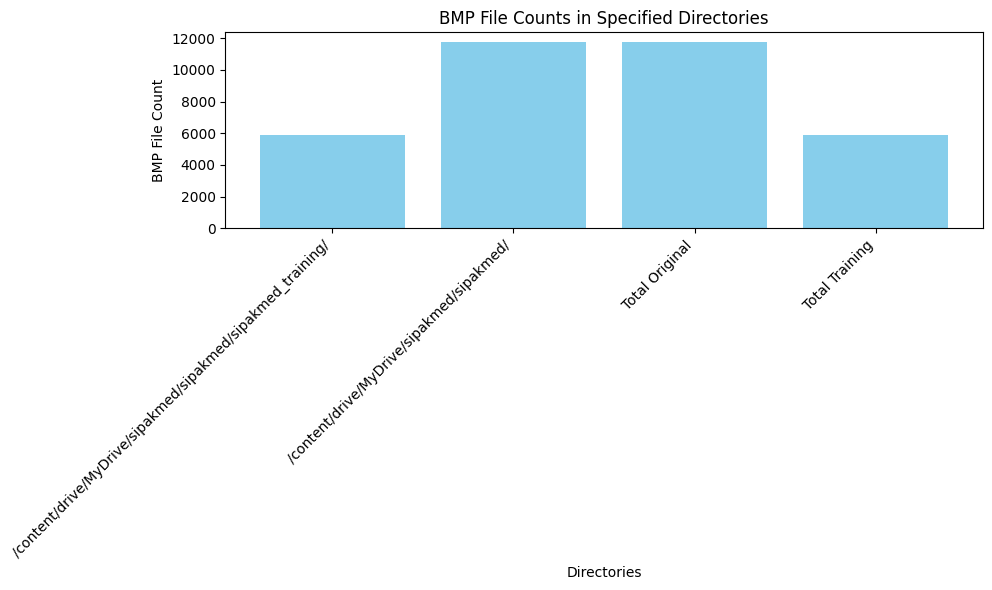

In [ ]:

!cp /content/drive/MyDrive/sipakmed/modular/check_balanced_data.py /content

import check_balanced_data
check_balanced_data.check_balanced_data()


check data balance in normal and atypical

In [ ]:
import libraries
import dataset_management

# Function to balance data by randomly undersampling the majority class
def balance_data(train_files):
    normal_files = [file for file in train_files if 'normal' in file]
    atypical_files = [file for file in train_files if 'atypical' in file]

    min_samples = min(len(normal_files), len(atypical_files))

    balanced_data = libraries.random.sample(normal_files, min_samples) + libraries.random.sample(atypical_files, min_samples)
    return balanced_data


In [ ]:

def check_balance(data):
    normal_count = sum(1 for file in data if 'normal' in file)
    atypical_count = sum(1 for file in data if 'atypical' in file)

    return normal_count, atypical_count

# Call the balance_data function to get the balanced dataset
balanced_train_data = balance_data(train_files)

# Check the balance
normal_count, atypical_count = check_balance(balanced_train_data)
print(f"Normal samples: {normal_count}, Atypical samples: {atypical_count}")

if normal_count == atypical_count:
    print("The data is balanced.")
else:
    print("The data is not balanced.")


Data preprocessing and loading using torchvision


 load images and their labels from the balanced_dataset:

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/data_loading.py /content
import data_loading

Do you want to apply data processing? (y/n): n
Data processing skipped.
Number of images in 'normal' class: 1159
Number of images in 'atypical' class: 1005


defining model architicture


In [ ]:

import libraries
from torchvision.models import resnet50  # Import ResNet-50
PREPROCESSED_PATH = "/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/preprocessed_classified/"

# Model
class ResNet50Model(libraries.nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50Model, self).__init__()
        self.model = resnet50(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

from torchvision import transforms

# Update the PTImageDataset class
class PTImageDataset(libraries.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.files = self.get_files(data_dir)
        self.num_classes = 2  # Assuming you have 2 classes
        self.class_names = ["normal", "abnormal"]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img_tensor = torch.load(img_path)

        # Apply transformations if specified
        if self.transform:
            img_tensor = self.transform(img_tensor)

        # Extract label from the file path or filename
        label = self.extract_label(img_path)

        return img_tensor, label

    def extract_label(self, file_path):
        # Modify this logic based on your actual file naming or directory structure
        parts = file_path.split(os.path.sep)
        class_name = parts[-2]
        return 0 if class_name == "normal" else 1  # Adjust based on your class names

    def get_files(self, data_dir):
        all_files = []
        for root, dirs, files in libraries.os.walk(data_dir):
            for file in files:
                if file.endswith(".pt"):
                    all_files.append(libraries.os.path.join(root, file))
        return all_files



In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        epoch_acc += correct / total

    epoch_loss /= len(train_loader.dataset)
    epoch_acc /= len(train_loader.dataset)

    return epoch_loss, epoch_acc

# Placeholder for the test function
def test(model, test_loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            epoch_loss += criterion(outputs, labels).item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            epoch_acc += correct

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss /= len(test_loader.dataset)
    epoch_acc /= len(test_loader.dataset)

    return epoch_loss, epoch_acc, all_preds, all_labels

# Dataset and dataloaders
PREPROCESSED_PATH = "/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/preprocessed_classified/"
dataset = PTImageDataset(PREPROCESSED_PATH)
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = libraries.random_split(dataset, [train_size, val_size, test_size])

train_loader = libraries.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = libraries.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = libraries.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import os
from torchvision.models import resnet50
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

# Model, optimizer, loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Check if a pre-trained model should be loaded
load_pretrained = input("Do you want to load a pre-trained model? (yes/no): ").lower()

if load_pretrained == "yes":
    # Check if a previously saved model exists
    saved_model_path = "resnet50_adam.pth"  # Adjust the filename as needed
    if os.path.exists(saved_model_path):
        model.load_state_dict(torch.load(saved_model_path))
        print("Pre-trained model loaded.")
    else:
        print(f"No pre-trained model found at {saved_model_path}. Training a new model.")
        load_pretrained = "no"

if load_pretrained != "yes":
    # Training loop
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    # Early stopping
    patience = 5
    best_val_loss = float('inf')  # Initialize here
    epochs_no_improve = 0

    for epoch in range(50):
        # Training
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)

        # Validation
        val_loss, val_acc, _, _ = test(model, val_loader, criterion)

        print(f"Epoch {epoch + 1} - "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
              f"Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f}")

        # Append metrics for later plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_acc)
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping!")
            break

    # Testing
    test_loss, test_acc, test_preds, test_labels = test(model, test_loader, criterion)
    print(f"Final Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 42.8MB/s]


Do you want to load a pre-trained model? (yes/no): n
Epoch 1 - Train Loss: 0.2315 Train Acc: 0.0568 Validation Loss: 0.0870 Validation Acc: 0.9630
Epoch 2 - Train Loss: 0.1030 Train Acc: 0.0607 Validation Loss: 0.0790 Validation Acc: 0.9722
Epoch 3 - Train Loss: 0.0733 Train Acc: 0.0616 Validation Loss: 0.0842 Validation Acc: 0.9745
Epoch 4 - Train Loss: 0.0562 Train Acc: 0.0619 Validation Loss: 0.1122 Validation Acc: 0.9699
Epoch 5 - Train Loss: 0.1271 Train Acc: 0.0603 Validation Loss: 0.0772 Validation Acc: 0.9815
Epoch 6 - Train Loss: 0.0286 Train Acc: 0.0627 Validation Loss: 0.0626 Validation Acc: 0.9838
Epoch 7 - Train Loss: 0.0610 Train Acc: 0.0621 Validation Loss: 0.0791 Validation Acc: 0.9653
Epoch 8 - Train Loss: 0.0457 Train Acc: 0.0619 Validation Loss: 0.0691 Validation Acc: 0.9838
Epoch 9 - Train Loss: 0.0798 Train Acc: 0.0612 Validation Loss: 0.0946 Validation Acc: 0.9699
Epoch 10 - Train Loss: 0.0498 Train Acc: 0.0620 Validation Loss: 0.0503 Validation Acc: 0.9815
Epoch 

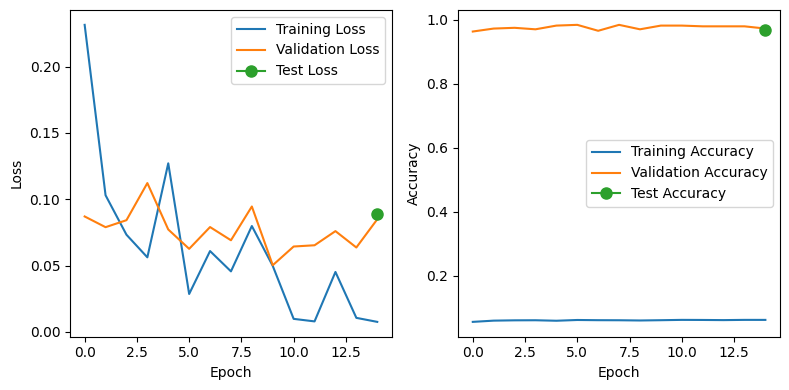

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/acc_loss_curves.py /content
import acc_loss_curves

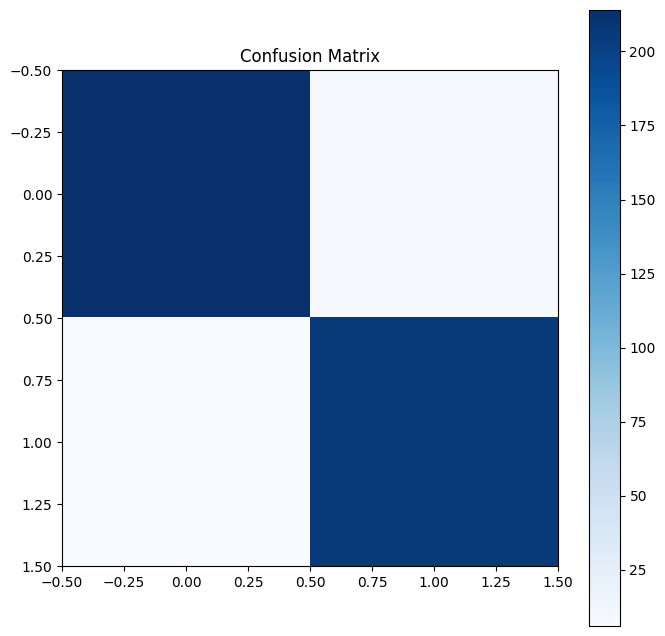

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/confusion_matrix.py /content
import confusion_matrix

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/evaluation_metrics.py /content
import evaluation_metrics


F1 Score: 0.9677
Precision: 0.9678
Recall: 0.9677
Classification Report:
               precision    recall  f1-score   support

      normal       0.97      0.96      0.97       222
    abnormal       0.96      0.97      0.97       212

    accuracy                           0.97       434
   macro avg       0.97      0.97      0.97       434
weighted avg       0.97      0.97      0.97       434

Do you want to save the trained model? (yes/no): y


 Evaluation Metrics:
 - F1 Score (0.9374): A balanced measure of precision and recall.
 - Precision (0.9416): The accuracy of positive predictions.
 - Recall (0.9378): The ability to identify all relevant instances.
 - Classification Report: Detailed metrics for each class ("normal" and "abnormal").
   - For "normal": High precision (few false positives), moderate recall.
   - For "abnormal": Good precision, very high recall (few false negatives).
 - Accuracy (0.94): Overall correct predictions.
 - Macro Avg and Weighted Avg: Averages for precision, recall, and F1-score.
In summary, the model seems to perform well with a good balance between precision and recall. The detailed classification report provides insights into the performance for each class.






In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Number of trainable parameters in the model: {num_params}")


Number of trainable parameters in the model: 23512130


In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/sample_input_time.py /content
import sample_input_time

Inference time for a sample input: 0.3257710933685303 seconds


In [ ]:
from torchsummary import summary

# Instantiate the model
model = ResNet50Model()

# Define a function to print a concise summary
def concise_summary(model, input_size):
    summary(model, input_size, device="cuda" if torch.cuda.is_available() else "cpu")

# Print the concise summary
input_size = (3, 125, 125)
concise_summary(model, input_size)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]           9,408
       BatchNorm2d-2           [-1, 64, 63, 63]             128
              ReLU-3           [-1, 64, 63, 63]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,